In [1]:
# 39개 마커
MARKERS = ['LFHD', 'RFHD', 'LBHD', 'RBHD', 'C7', 'LSHO', 'RSHO', 'CLAV', 'RBAK',
           'LUPA', 'RUPA', 'STRN', 'T10', 'LELB', 'RELB', 'LFRM', 'RFRM',
           'LWRA', 'RWRA', 'LWRB', 'RWRB', 'LFIN', 'RFIN', 'LASI', 'RASI',
           'LPSI', 'RPSI', 'LTHI', 'RTHI', 'LKNE', 'RKNE', 'LTIB', 'RTIB',
           'LANK', 'RANK', 'LTOE', 'RTOE', 'LHEE', 'RHEE']
len(MARKERS)

39

In [4]:
import os
import glob

import pandas as pd
import numpy as np
from PIL import Image 
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from ..utils import gradcam

In [5]:
DATAPATH = "/Users/sujinlee/Desktop/nims/pd/dataset"
CONTROL = os.path.join(DATAPATH, "Controls")
PD = os.path.join(DATAPATH, "PD")

df_patients = pd.read_csv(os.path.join(DATAPATH, "patients.csv"))
df_null_info = pd.read_csv(os.path.join(DATAPATH, "NULL_info.csv"))

In [6]:
HEIGHT = 200
WIDTH = 39
BATCH_SIZE = 1

TRAIN_DATA_PATH = DATAPATH + "_img"

train_datagen = ImageDataGenerator(
    #Your code here. Should at least have a rescale. Other parameters can help with overfitting.)
    rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_PATH,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    classes=['Controls', 'PD'],
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_PATH, # same directory as training data
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    classes=['Controls', 'PD'],
    class_mode='binary',
    subset='validation') # set as validation data

Found 461 images belonging to 2 classes.
Found 114 images belonging to 2 classes.


In [7]:
import tensorflow.keras.layers as tfl
from tensorflow.keras.optimizers import Adam

In [8]:
# Note the input shape specified on your first layer must be (300,300,3)
# You should not change the last layer

model = tf.keras.models.Sequential([tfl.Conv2D(16, (1,7), (2,1), activation='relu', input_shape=(200,39,3)),
                                    tfl.MaxPooling2D((2,2),(2,1)), 
                                    tfl.ZeroPadding2D(1),
                                    tfl.Conv2D(32, (1,7), (2,2), activation='relu'),
                                    tfl.MaxPooling2D((2,2),(2,2)), 
                                    tfl.Flatten(),
                                    tfl.Dense(512, activation='relu'),
                                    tfl.Dropout(0.5),
                                    tfl.Dense(64, activation='relu'),
                                    tfl.Dropout(0.5),
                                    tfl.Dense(1, activation='sigmoid')])

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

2022-06-10 07:42:24.573355: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 33, 16)       352       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 32, 16)        0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 52, 34, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 14, 32)        3616      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 7, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2912)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1

In [10]:
from sklearn.utils import class_weight 
import numpy as np

class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)

/Users/sujinlee/.virtualenvs/ml/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [11]:
train_class_weights = dict(enumerate(class_weights))

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='loss', patience=5)

In [13]:
history = model.fit_generator(
                train_generator,
                steps_per_epoch = train_generator.samples // BATCH_SIZE,
                validation_data = validation_generator, 
                validation_steps = validation_generator.samples // BATCH_SIZE,
                class_weight = train_class_weights,
                epochs = 100,
                callbacks = [callback])

/Users/sujinlee/.virtualenvs/ml/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-06-10 07:42:37.414641: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
461/461 [==============================] - 3s 6ms/step - loss: 0.7079 - accuracy: 0.6074 - val_loss: 0.6559 - val_accuracy: 0.7807
Epoch 2/100
461/461 [==============================] - 3s 6ms/step - loss: 0.6892 - accuracy: 0.5900 - val_loss: 0.5517 - val_accuracy: 0.7982
Epoch 3/100
461/461 [==============================] - 3s 6ms/step - loss: 0.6841 - accuracy: 0.6464 - val_loss: 0.6909 - val_accuracy: 0.5000
Epoch 4/100
461/461 [==============================] - 3s 6ms/step - loss: 0.6540 - accuracy: 0.6312 - val_loss: 0.6263 - val_accuracy: 0.7368
Epoch 5/100
461/461 [==============================] - 2s 5ms/step - loss: 0.6439 - accuracy: 0.6573 - val_loss: 0.7807 - val_accuracy: 0.3772
Epoch 6/100
461/461 [==============================] - 2s 5ms/step - loss: 0.6203 - accuracy: 0.6681 - val_loss: 0.6672 - val_accuracy: 0.5439
Epoch 7/100
461/461 [==============================] - 2s 5ms/step - loss: 0.5978 - accuracy: 0.6573 - val_loss: 0.6638 - val_accuracy: 0.6053

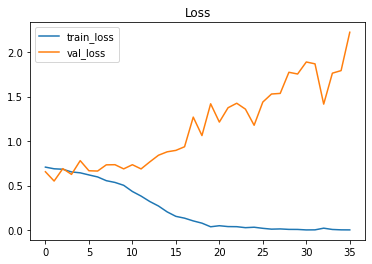

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label='train_loss')
plt.plot(history.history["val_loss"], label='val_loss')
plt.legend()
plt.title("Loss")
plt.show()

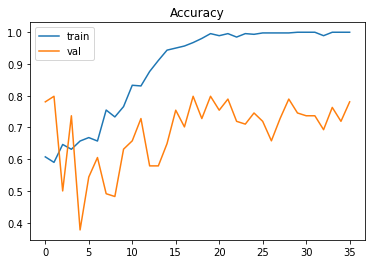

In [15]:
plt.plot(history.history["accuracy"], label='train')
plt.plot(history.history["val_accuracy"], label='val')
plt.legend()
plt.title("Accuracy")
plt.show()